# Latent Dirichlet Allocation for Text Data

In this assignment you will

* apply standard preprocessing techniques on Wikipedia text data
* use GraphLab Create to fit a Latent Dirichlet allocation (LDA) model
* explore and interpret the results, including topic keywords and topic assignments for documents

Recall that a major feature distinguishing the LDA model from our previously explored methods is the notion of *mixed membership*. Throughout the course so far, our models have assumed that each data point belongs to a single cluster. k-means determines membership simply by shortest distance to the cluster center, and Gaussian mixture models suppose that each data point is drawn from one of their component mixture distributions. In many cases, though, it is more realistic to think of data as genuinely belonging to more than one cluster or category - for example, if we have a model for text data that includes both "Politics" and "World News" categories, then an article about a recent meeting of the United Nations should have membership in both categories rather than being forced into just one.

With this in mind, we will use GraphLab Create tools to fit an LDA model to a corpus of Wikipedia articles and examine the results to analyze the impact of a mixed membership approach. In particular, we want to identify the topics discovered by the model in terms of their most important words, and we want to use the model to predict the topic membership distribution for a given document. 

**Note to Amazon EC2 users**: To conserve memory, make sure to stop all the other notebooks before running this notebook.

## Text Data Preprocessing
We'll start by importing our familiar Wikipedia dataset.

The following code block will check if you have the correct version of GraphLab Create. Any version later than 1.8.5 will do. To upgrade, read [this page](https://turi.com/download/upgrade-graphlab-create.html).

In [1]:
import graphlab as gl
import numpy as np
import matplotlib.pyplot as plt 

%matplotlib inline

'''Check GraphLab Create version'''
from distutils.version import StrictVersion
assert (StrictVersion(gl.version) >= StrictVersion('1.8.5')), 'GraphLab Create must be version 1.8.5 or later.'

This non-commercial license of GraphLab Create for academic use is assigned to damor4321@gmail.com and will expire on January 29, 2018.


[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1505901721.log


In [2]:
# import wiki data
wiki = gl.SFrame('datasets/people_wiki.gl/')
wiki

URI,name,text
<http://dbpedia.org/resource/Digby_Morrell> ...,Digby Morrell,digby morrell born 10october 1979 is a former ...
<http://dbpedia.org/resource/Alfred_J._Lewy> ...,Alfred J. Lewy,alfred j lewy aka sandylewy graduated from ...
<http://dbpedia.org/resource/Harpdog_Brown> ...,Harpdog Brown,harpdog brown is a singerand harmonica player who ...
<http://dbpedia.org/resource/Franz_Rottensteiner> ...,Franz Rottensteiner,franz rottensteiner bornin waidmannsfeld lower ...
<http://dbpedia.org/resource/G-Enka> ...,G-Enka,henry krvits born 30december 1974 in tallinn ...
<http://dbpedia.org/resource/Sam_Henderson> ...,Sam Henderson,sam henderson bornoctober 18 1969 is an ...
<http://dbpedia.org/resource/Aaron_LaCrate> ...,Aaron LaCrate,aaron lacrate is anamerican music producer ...
<http://dbpedia.org/resource/Trevor_Ferguson> ...,Trevor Ferguson,trevor ferguson aka johnfarrow born 11 november ...
<http://dbpedia.org/resource/Grant_Nelson> ...,Grant Nelson,grant nelson born 27april 1971 in london ...
<http://dbpedia.org/resource/Cathy_Caruth> ...,Cathy Caruth,cathy caruth born 1955 isfrank h t rhodes ...


In the original data, each Wikipedia article is represented by a URI, a name, and a string containing the entire text of the article. Recall from the video lectures that LDA requires documents to be represented as a _bag of words_, which ignores word ordering in the document but retains information on how many times each word appears. As we have seen in our previous encounters with text data, words such as 'the', 'a', or 'and' are by far the most frequent, but they appear so commonly in the English language that they tell us almost nothing about how similar or dissimilar two documents might be. 

Therefore, before we train our LDA model, we will preprocess the Wikipedia data in two steps: first, we will create a bag of words representation for each article, and then we will remove the common words that don't help us to distinguish between documents. For both of these tasks we can use pre-implemented tools from GraphLab Create:

In [3]:
wiki_docs = gl.text_analytics.count_words(wiki['text'])
wiki_docs = wiki_docs.dict_trim_by_keys(gl.text_analytics.stopwords(), exclude=True)

In [4]:
#DAF understanding
print wiki[1]
print "\n",wiki_docs[1]
#gl.text_analytics.stopwords()

{'text': 'alfred j lewy aka sandy lewy graduated from university of chicago in 1973 after studying psychiatry pharmacology and ophthalmology he is a full professor and vicechair of the department of psychiatry at ohsu oregon health science university and holds an md and phd prior to moving to oregon in 1981 lewy was at the national institute of mental health nimh in bethesda maryland working with senior colleague thomas wehr in oregon he has worked closely with robert l sack as of december 2005 he had 94 publications available on pubmed he describes his research as follows my laboratory studies chronobiologic sleep and mood disorders these disorders include winter depression jet lag maladaptation to shift work and certain types of sleep disturbances relying on a very precise assay for plasma melatonin a hormone that has a clearly defined 24hour pattern of secretion biological rhythm disorders can be assessed and their treatment can be monitored current research is focused on developing

## Model fitting and interpretation
In the video lectures we saw that Gibbs sampling can be used to perform inference in the LDA model. In this assignment we will use a GraphLab Create method to learn the topic model for our Wikipedia data, and our main emphasis will be on interpreting the results. We'll begin by creating the topic model using create() from GraphLab Create's topic_model module.

Note: This may take several minutes to run.

In [5]:
topic_model = gl.topic_model.create(wiki_docs, num_topics=10, num_iterations=200)
#topic_model = gl.topic_model.create(wiki_docs, num_topics=10, num_iterations=11)

Learning a topic model

Number of documents     59071

Vocabulary size    547462

Running collapsed Gibbs sampling

+-----------+---------------+----------------+-----------------+

| Iteration | Elapsed Time  | Tokens/Second  | Est. Perplexity |

+-----------+---------------+----------------+-----------------+

| 10        | 18.37s        | 4.7591e+06     | 0               |

| 11        | 20.03s        | 4.79083e+06    | 0               |

+-----------+---------------+----------------+-----------------+

GraphLab provides a useful summary of the model we have fitted, including the hyperparameter settings for alpha, gamma (note that GraphLab Create calls this parameter beta), and K (the number of topics); the structure of the output data; and some useful methods for understanding the results.

In [6]:
topic_model

Class                          : TopicModel

Schema
------
Vocabulary Size                : 547462

Settings
--------
Number of Topics               : 10
alpha                          : 5.0
beta                           : 0.1
Iterations                     : 11
Training time                  : 21.0351
Verbose                        : False

Accessible fields             : 
m['topics']                   : An SFrame containing the topics.
m['vocabulary']               : An SArray containing the words in the vocabulary.
Useful methods                : 
m.get_topics()                : Get the most probable words per topic.
m.predict(new_docs)           : Make predictions for new documents.

In [22]:
#DAF understanding. Despues de corrido el fit de topic_model con 11 iteraciones para no quemar el computer.

print topic_model

print "\n", topic_model['topics'] #las palabras de vocab y las prob asociadas para cada uno de los 10 topics.
# En LDA un topic es una distribucion del vocab corpus-wide simplemente. Aqui tenemos 10 distribs distintas del vocabulary

print "\n", topic_model['topics'][1] #La palabra 'college' en top5 del topic3: dado topic3, su P. de aparecer es la mayor

print "\n", topic_model['vocabulary'] , "\n" #sin más sarray de todas las palabras del vocabulary

topic_model.get_topics().print_rows(50) #By default Top5 de "las tablas" de "(corpus-wide) topic vocabulary distributions"
#... pero se puede usar así: topic_model.get_topics(topic_ids=[i], num_words=100)['score']

+-------------------------------+-------------+
|      topic_probabilities      |  vocabulary |
+-------------------------------+-------------+
| [1.01449901705e-07, 9.2803... |  melbourne  |
| [0.00256475496501, 0.00119... |   college   |
| [3.25654184473e-05, 9.3731... |    parade   |
| [1.01449901705e-07, 9.2803... |  education  |
| [1.01449901705e-07, 9.2803... |   teaches   |
| [1.01449901705e-07, 1.0208... |    edflhe   |
| [1.01449901705e-07, 9.2803... |    coburg   |
| [1.01449901705e-07, 9.2803... |   coached   |
| [1.01449901705e-07, 9.2803... | premiership |
| [0.00179170671401, 2.87689... |   division  |
+-------------------------------+-------------+
[547462 rows x 2 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.

{'vocabulary': 'melbourne', 'topic_probabilities': array('d', [1.0144990170511328e-07, 9.280301483608217e-08, 8.537076351895967e-08, 7.0573201793811e-05, 9.797362051401268e-

It is certainly useful to have pre-implemented methods available for LDA, but as with our previous methods for clustering and retrieval, implementing and fitting the model gets us only halfway towards our objective. We now need to analyze the fitted model to understand what it has done with our data and whether it will be useful as a document classification system. This can be a challenging task in itself, particularly when the model that we use is complex. We will begin by outlining a sequence of objectives that will help us understand our model in detail. In particular, we will

* get the top words in each topic and use these to identify topic themes
* predict topic distributions for some example documents
* compare the quality of LDA "nearest neighbors" to the NN output from the first assignment
* understand the role of model hyperparameters alpha and gamma

## Load a fitted topic model
The method used to fit the LDA model is a _randomized algorithm_, which means that it involves steps that are random; in this case, the randomness comes from Gibbs sampling, as discussed in the LDA video lectures. Because of these random steps, the algorithm will be expected to yield slighty different output for different runs on the same data - note that this is different from previously seen algorithms such as k-means or EM, which will always produce the same results given the same input and initialization.

It is important to understand that variation in the results is a fundamental feature of randomized methods. However, in the context of this assignment this variation makes it difficult to evaluate the correctness of your analysis, so we will load and analyze a pre-trained model. 

We recommend that you spend some time exploring your own fitted topic model and compare our analysis of the pre-trained model to the same analysis applied to the model you trained above.

In [23]:
topic_model = gl.load_model('lda_models/lda_assignment_topic_model')

In [28]:
#DAF understanding. Modelo pre-trained con 200 iteraciones

print topic_model

print "\n", topic_model['topics'] #las palabras de vocab y las prob asociadas para cada uno de los 10 topics.
# En LDA un topic es una distribucion del vocab corpus-wide simplemente. Aqui tenemos 10 distribs distintas del vocabulary

print "\n", topic_model['topics'][1] #La palabra 'college' en top5 del topic3: dado topic3, su P. de aparecer es la mayor

print "\n", topic_model['vocabulary'] , "\n" #sin más sarray de todas las palabras del vocabulary

topic_model.get_topics().print_rows(50) #By default Top5 de "las tablas" de "(corpus-wide) topic vocabulary distributions"
#... pero se puede usar así: topic_model.get_topics(topic_ids=[i], num_words=100)['score']

Class                          : TopicModel

Schema
------
Vocabulary Size                : 547462

Settings
--------
Number of Topics               : 10
alpha                          : 5.0
beta                           : 0.1
Iterations                     : 200
Training time                  : 363.9111
Verbose                        : False

Accessible fields             : 
m['topics']                   : An SFrame containing the topics.
m['vocabulary']               : An SArray containing the words in the vocabulary.
Useful methods                : 
m.get_topics()                : Get the most probable words per topic.
m.predict(new_docs)           : Make predictions for new documents.

+-------------------------------+-------------+
|      topic_probabilities      |  vocabulary |
+-------------------------------+-------------+
| [8.76815182796e-08, 1.7784... |  melbourne  |
| [0.00340476103631, 0.00095... |   college   |
| [8.76815182796e-08, 2.8879... |    parade   |
| [0.0040018

# Identifying topic themes by top words

We'll start by trying to identify the topics learned by our model with some major themes. As a preliminary check on the results of applying this method, it is reasonable to hope that the model has been able to learn topics that correspond to recognizable categories. In order to do this, we must first recall what exactly a 'topic' is in the context of LDA. 

In the video lectures on LDA we learned that a topic is a probability distribution over words in the vocabulary; that is, each topic assigns a particular probability to every one of the unique words that appears in our data. Different topics will assign different probabilities to the same word: for instance, a topic that ends up describing science and technology articles might place more probability on the word 'university' than a topic that describes sports or politics. Looking at the highest probability words in each topic will thus give us a sense of its major themes. Ideally we would find that each topic is identifiable with some clear theme _and_ that all the topics are relatively distinct.

We can use the GraphLab Create function get_topics() to view the top words (along with their associated probabilities) from each topic.

__Quiz Question:__ Identify the top 3 most probable words for the first topic. 

__ Quiz Question:__ What is the sum of the probabilities assigned to the top 50 words in the 3rd topic?

In [159]:
print topic_model.get_topics(topic_ids=[0], num_words=3)
print
print sum(topic_model.get_topics(topic_ids=[2], num_words=50)['score'])
#DAF: print sum(topic_model.get_topics(topic_ids=[2], num_words=547462)['score']) da = 1


+-------+------------+-----------------+
| topic |    word    |      score      |
+-------+------------+-----------------+
|   0   | university | 0.0337723780773 |
|   0   |  research  | 0.0120334992502 |
|   0   | professor  | 0.0118011432268 |
+-------+------------+-----------------+
[3 rows x 3 columns]


0.210343660789


Let's look at the top 10 words for each topic to see if we can identify any themes:

In [58]:
#DAF understanding
[x['words'] for x in topic_model.get_topics(output_type='topic_words', num_words=10)]

[['university',
  'research',
  'professor',
  'international',
  'institute',
  'science',
  'society',
  'studies',
  'director',
  'national'],
 ['played',
  'season',
  'league',
  'team',
  'career',
  'football',
  'games',
  'player',
  'coach',
  'game'],
 ['film',
  'music',
  'album',
  'released',
  'band',
  'television',
  'series',
  'show',
  'award',
  'appeared'],
 ['university',
  'school',
  'served',
  'college',
  'state',
  'american',
  'states',
  'united',
  'born',
  'law'],
 ['member',
  'party',
  'election',
  'minister',
  'government',
  'elected',
  'served',
  'president',
  'general',
  'committee'],
 ['work',
  'art',
  'book',
  'published',
  'york',
  'magazine',
  'radio',
  'books',
  'award',
  'arts'],
 ['company',
  'business',
  'years',
  'group',
  'time',
  'family',
  'people',
  'india',
  'million',
  'indian'],
 ['world',
  'won',
  'born',
  'time',
  'year',
  'team',
  'championship',
  'tour',
  'championships',
  'title'],
 ['born

We propose the following themes for each topic:

- topic 0: Science and research
- topic 1: Team sports
- topic 2: Music, TV, and film
- topic 3: American college and politics
- topic 4: General politics
- topic 5: Art and publishing
- topic 6: Business
- topic 7: International athletics
- topic 8: Great Britain and Australia
- topic 9: International music

We'll save these themes for later:

In [59]:
themes = ['science and research','team sports','music, TV, and film','American college and politics','general politics', \
         'art and publishing','Business','international athletics','Great Britain and Australia','international music']

### Measuring the importance of top words

We can learn more about topics by exploring how they place probability mass (which we can think of as a weight) on each of their top words.

We'll do this with two visualizations of the weights for the top words in each topic:
 - the weights of the top 100 words, sorted by the size
 - the total weight of the top 10 words


Here's a plot for the top 100 words by weight in each topic:

In [64]:
# DAF understanding
topic_model.get_topics(topic_ids=[0], num_words=100)['score']

dtype: float
Rows: 100
[0.03377237807725826, 0.012033499250205755, 0.011801143226764909, 0.008813833898980135, 0.008510455845732842, 0.00837981038349629, 0.00654814346663618, 0.006458708317991025, 0.006314033812829743, 0.005795836039797515, 0.005597675808485698, 0.005544190082335163, 0.005393377870894312, 0.005245196105001847, 0.004997057408270679, 0.004763824569647037, 0.004711215658679298, 0.004516562688098664, 0.004510424981819095, 0.004449047919023399, 0.004178112027539544, 0.004153561202421266, 0.0041316408228513745, 0.0040246693705503055, 0.004001872175797619, 0.0038896398323997753, 0.003805465574851393, 0.003436326382894425, 0.0034047610363137815, 0.00330831136620626, 0.003298666399195508, 0.0032197530327438997, 0.0031504846333030435, 0.0031452237422062695, 0.0031373324055611086, 0.0031294410689159478, 0.0030724480820342307, 0.0030557885935611133, 0.003021592801432083, 0.003004933312958966, 0.0029470635108944532, 0.0029391721742492924, 0.0028742878507224145, 0.002824309385303062

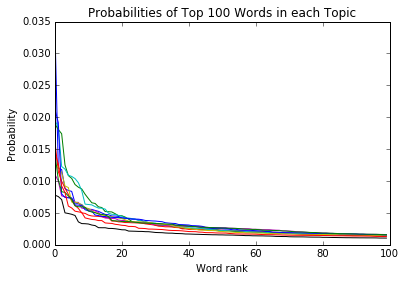

In [63]:
for i in range(10):
    plt.plot(range(100), topic_model.get_topics(topic_ids=[i], num_words=100)['score'])
plt.xlabel('Word rank')
plt.ylabel('Probability')
plt.title('Probabilities of Top 100 Words in each Topic')

In the above plot, each line corresponds to one of our ten topics. Notice how for each topic, the weights drop off sharply as we move down the ranked list of most important words. This shows that the top 10-20 words in each topic are assigned a much greater weight than the remaining words - and remember from the summary of our topic model that our vocabulary has 547462 words in total!


Next we plot the total weight assigned by each topic to its top 10 words: 

In [67]:
np.arange(10)
top_probs = [sum(topic_model.get_topics(topic_ids=[i], num_words=10)['score']) for i in range(10)]
print top_probs

[0.10842784231969266, 0.12338367462561742, 0.08309116123904615, 0.11869171409612293, 0.07568004752488791, 0.08636736369933445, 0.05197049157967558, 0.0947122485546823, 0.07965265837594167, 0.07613543837970821]


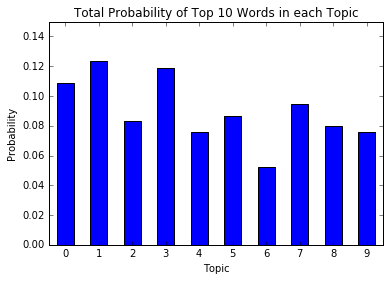

In [66]:
top_probs = [sum(topic_model.get_topics(topic_ids=[i], num_words=10)['score']) for i in range(10)]

ind = np.arange(10)
width = 0.5

fig, ax = plt.subplots()

ax.bar(ind-(width/2),top_probs,width)
ax.set_xticks(ind)

plt.xlabel('Topic')
plt.ylabel('Probability')
plt.title('Total Probability of Top 10 Words in each Topic')
plt.xlim(-0.5,9.5)
plt.ylim(0,0.15)
plt.show()

Here we see that, for our topic model, the top 10 words only account for a small fraction (in this case, between 5% and 13%) of their topic's total probability mass. So while we can use the top words to identify broad themes for each topic, we should keep in mind that in reality these topics are more complex than a simple 10-word summary.

Finally, we observe that some 'junk' words appear highly rated in some topics despite our efforts to remove unhelpful words before fitting the model; for example, the word 'born' appears as a top 10 word in three different topics, but it doesn't help us describe these topics at all.

# Topic distributions for some example documents

As we noted in the introduction to this assignment, LDA allows for mixed membership, which means that each document can partially belong to several different topics. For each document, topic membership is expressed as a vector of weights that sum to one; the magnitude of each weight indicates the degree to which the document represents that particular topic.

We'll explore this in our fitted model by looking at the topic distributions for a few example Wikipedia articles from our data set. We should find that these articles have the highest weights on the topics whose themes are most relevant to the subject of the article - for example, we'd expect an article on a politician to place relatively high weight on topics related to government, while an article about an athlete should place higher weight on topics related to sports or competition.

Topic distributions for documents can be obtained using GraphLab Create's predict() function. GraphLab Create uses a collapsed Gibbs sampler similar to the one described in the video lectures, where only the word assignments variables are sampled.  To get a document-specific topic proportion vector post-facto, predict() draws this vector from the conditional distribution given the sampled word assignments in the document.  Notice that, since these are draws from a _distribution_ over topics that the model has learned, we will get slightly different predictions each time we call this function on a document - we can see this below, where we predict the topic distribution for the article on Barack Obama:

In [68]:
obama = gl.SArray([wiki_docs[int(np.where(wiki['name']=='Barack Obama')[0])]])
pred1 = topic_model.predict(obama, output_type='probability')
pred2 = topic_model.predict(obama, output_type='probability')
print(gl.SFrame({'topics':themes, 'predictions (first draw)':pred1[0], 'predictions (second draw)':pred2[0]}))

+--------------------------+---------------------------+
| predictions (first draw) | predictions (second draw) |
+--------------------------+---------------------------+
|     0.0403225806452      |      0.0349462365591      |
|     0.0591397849462      |      0.0645161290323      |
|     0.0215053763441      |      0.0215053763441      |
|      0.10752688172       |       0.123655913978      |
|      0.604838709677      |       0.612903225806      |
|     0.0134408602151      |      0.0241935483871      |
|     0.0483870967742      |      0.0376344086022      |
|     0.0510752688172      |      0.0188172043011      |
|     0.0188172043011      |      0.0322580645161      |
|     0.0349462365591      |      0.0295698924731      |
+--------------------------+---------------------------+
+-------------------------------+
|             topics            |
+-------------------------------+
|      science and research     |
|          team sports          |
|      music, TV, and film      

In [75]:
#DAF understanding
print obama
print pred1[0]

[{'operations': 1, 'represent': 1, 'office': 2, 'unemployment': 1, 'administration': 1, 'unconstitutional': 1, 'domestic': 2, 'major': 1, 'ending': 1, 'ended': 1, 'proposition': 1, 'seats': 1, 'illinois': 2, 'debate': 1, 'death': 1, '20': 2, 'californias': 1, 'taxpayer': 1, 'inaugurated': 1, 'obamacare': 1, 'barack': 1, 'wall': 1, '4': 1, 'policy': 2, '8': 1, '2011': 3, '2010': 2, '2013': 1, '2012': 1, 'bin': 1, 'march': 1, 'increased': 1, 'cuba': 1, 'term': 3, 'made': 1, 'years': 1, 'continued': 1, 'presidential': 2, 'husen': 1, 'school': 3, 'equality': 1, 'prize': 1, 'lost': 1, 'stimulus': 1, 'january': 3, 'university': 2, '1996': 1, 'july': 1, 'hawaii': 1, 'victory': 1, 'withdrawal': 1, 'americans': 1, 'referred': 1, 'unsuccessfully': 1, 'attorney': 1, 'senate': 3, 'house': 2, 'national': 2, 'creation': 1, 'related': 1, 'gun': 1, 'born': 2, 'street': 1, 'election': 3, 'close': 1, 'operation': 1, 'insurance': 1, 'sandy': 1, 'afghanistan': 2, 'initiatives': 1, 'reform': 1, 'federal': 

To get a more robust estimate of the topics for each document, we can average a large number of predictions for the same document:

In [76]:
def average_predictions(model, test_document, num_trials=100):
    avg_preds = np.zeros((model.num_topics))
    for i in range(num_trials):
        avg_preds += model.predict(test_document, output_type='probability')[0]
    avg_preds = avg_preds/num_trials
    result = gl.SFrame({'topics':themes, 'average predictions':avg_preds})
    result = result.sort('average predictions', ascending=False)
    return result

In [77]:
print average_predictions(topic_model, obama, 100)

+---------------------+-------------------------------+
| average predictions |             topics            |
+---------------------+-------------------------------+
|    0.593709677419   |        general politics       |
|    0.13873655914    | American college and politics |
|   0.0519892473118   |            Business           |
|    0.049811827957   |          team sports          |
|   0.0405376344086   |      science and research     |
|   0.0342741935484   |    international athletics    |
|   0.0255376344086   |  Great Britain and Australia  |
|   0.0231451612903   |      international music      |
|   0.0227956989247   |       art and publishing      |
|   0.0194623655914   |      music, TV, and film      |
+---------------------+-------------------------------+
[10 rows x 2 columns]



__Quiz Question:__ What is the topic most closely associated with the article about former US President George W. Bush? Use the average results from 100 topic predictions.

In [161]:
bush = gl.SArray([wiki_docs[int(np.where(wiki['name']=='George W. Bush')[0])]])
print average_predictions(topic_model, bush, 100)

+---------------------+-------------------------------+
| average predictions |             topics            |
+---------------------+-------------------------------+
|    0.430409356725   |        general politics       |
|    0.189590643275   | American college and politics |
|    0.100877192982   |            Business           |
|   0.0587426900585   |      science and research     |
|   0.0498830409357   |       art and publishing      |
|   0.0457894736842   |          team sports          |
|   0.0375438596491   |  Great Britain and Australia  |
|   0.0364912280702   |    international athletics    |
|   0.0299122807018   |      music, TV, and film      |
|   0.0207602339181   |      international music      |
+---------------------+-------------------------------+
[10 rows x 2 columns]



__Quiz Question:__ What are the top 3 topics corresponding to the article about English football (soccer) player Steven Gerrard? Use the average results from 100 topic predictions.

In [78]:
gerrard = gl.SArray([wiki_docs[int(np.where(wiki['name']=='Steven Gerrard')[0])]])
print gerrard, "\n\n"
print average_predictions(topic_model, gerrard, 100)

[{'fifa': 2, 'ended': 1, 'world': 3, 'cementing': 1, 'captain': 2, 'galaxy': 1, 'cup': 4, 'countrys': 1, 'permanent': 1, 'hyypi': 1, 'win': 1, '2015': 1, '2014': 2, 'include': 1, 'footballer': 5, '2010': 1, 'wingergerrard': 1, '2012': 3, 'caps': 1, 'fan': 1, 'honours': 1, 'footballers': 1, 'entire': 1, 'captaining': 1, 'liverpoolgerrard': 1, 'debut': 2, 'gerrard': 5, 'team': 7, 'capsregarded': 1, 'european': 1, 'england': 3, 'ballon': 1, 'generation': 1, 'list': 1, 'national': 1, 'back': 1, '114': 1, 'year': 5, 'cups': 4, 'plays': 1, 'mls': 1, 'won': 2, 'honoured': 1, 'succeeding': 1, 'international': 2, 'tournaments': 1, 'sixth': 1, 'represented': 1, '100': 2, 'super': 1, 'bronze': 1, 'league': 5, 'central': 1, 'english': 2, 'career': 3, 'country': 1, '30': 1, 'fwa': 1, 'contract': 1, 'times': 2, 'players': 2, 'place': 1, '2013zinedine': 1, 'named': 4, 'xi': 1, 'mbe': 1, 'steven': 1, 'midfielder': 3, 'poll': 1, 'george': 1, '1980': 1, 'captains': 1, 'time': 1, 'kop': 1, 'final': 4, 'd

# Comparing LDA to nearest neighbors for document retrieval

So far we have found that our topic model has learned some coherent topics, we have explored these topics as probability distributions over a vocabulary, and we have seen how individual documents in our Wikipedia data set are assigned to these topics in a way that corresponds with our expectations. 

In this section, we will use the predicted topic distribution as a representation of each document, similar to how we have previously represented documents by word count or TF-IDF. This gives us a way of computing distances between documents, so that we can run a nearest neighbors search for a given document based on its membership in the topics that we learned from LDA. We can contrast the results with those obtained by running nearest neighbors under the usual TF-IDF representation, an approach that we explored in a previous assignment. 

We'll start by creating the LDA topic distribution representation for each document:

In [79]:
wiki['lda'] = topic_model.predict(wiki_docs, output_type='probability')

Next we add the TF-IDF document representations:

In [80]:
wiki['word_count'] = gl.text_analytics.count_words(wiki['text'])
wiki['tf_idf'] = gl.text_analytics.tf_idf(wiki['word_count'])

In [87]:
#DAF understanding
obama_row = wiki[ wiki['name']=='Barack Obama' ]
print obama_row['tf_idf'] , "\n"
print obama_row['lda'] , "\n\n"

# tiene muchos más parametros la representacion tf_idf (1 per word) que la lda (1 per topic weight)
print len(obama_row['tf_idf'][0]) , "\n", len(obama_row['lda'][0])

[{'operations': 3.811771079388818, 'represent': 4.184100625900883, 'office': 5.2481728232196465, 'unemployment': 6.642689967371511, 'is': 0.05523250095103998, 'doddfrank': 9.887883100557085, 'over': 1.4878231559557336, 'unconstitutional': 6.8276123058655225, 'domestic': 8.967410686619141, 'named': 2.0300155412252816, 'ending': 4.547145018125096, 'ended': 3.3430124821479934, 'proposition': 6.926052378678775, 'seats': 5.000043383940756, 'graduate': 2.6750971107885535, 'worked': 1.553891853362109, 'before': 1.4967823726683713, 'death': 3.1568650000750016, '20': 4.88376320446593, 'taxpayer': 7.431147327735781, 'inaugurated': 6.27696518791286, 'obamacare': 9.04058524016988, 'civil': 3.3244978303233013, 'mccain': 6.766987684049088, 'to': 0.6572291275451891, '4': 2.437803530749586, 'policy': 6.095386282141427, '8': 2.7572509724892824, 'has': 1.713990158976156, '2011': 5.107041270312876, '2010': 3.185667920243947, '2013': 1.9545642372230505, '2012': 1.7938099524877322, 'bin': 5.615857361097531

For each of our two different document representations, we can use GraphLab Create to compute a brute-force nearest neighbors model:

In [175]:
model_tf_idf = gl.nearest_neighbors.create(wiki, label='name', features=['tf_idf'],
                                           method='brute_force', distance='cosine')
model_lda_rep = gl.nearest_neighbors.create(wiki, label='name', features=['lda'],
                                            method='brute_force', distance='cosine')

Starting brute force nearest neighbors model training.

Starting brute force nearest neighbors model training.

Let's compare these nearest neighbor models by finding the nearest neighbors under each representation on an example document. For this example we'll use Paul Krugman, an American economist:

In [84]:
model_tf_idf.query(wiki[wiki['name'] == 'Paul Krugman'], label='name', k=10)

Starting pairwise querying.

+--------------+---------+-------------+--------------+

| Query points | # Pairs | % Complete. | Elapsed Time |

+--------------+---------+-------------+--------------+

| 0            | 1       | 0.00169288  | 59.195ms     |

| 0            | 56413   | 95.5003     | 1.05s        |

| Done         |         | 100         | 1.16s        |

+--------------+---------+-------------+--------------+

query_label,reference_label,distance,rank
Paul Krugman,Paul Krugman,0.0,1
Paul Krugman,Elise Brezis,0.744498017262,2
Paul Krugman,Maitreesh Ghatak,0.81564984831,3
Paul Krugman,Kai A. Konrad,0.823700564406,4
Paul Krugman,David Colander,0.834625927759,5
Paul Krugman,Richard Blundell,0.837934267874,6
Paul Krugman,Gordon Rausser,0.83941534706,7
Paul Krugman,Edward J. Nell,0.842178500015,8
Paul Krugman,Robin Boadway,0.842374260596,9
Paul Krugman,Tim Besley,0.843088109253,10


In [85]:
model_lda_rep.query(wiki[wiki['name'] == 'Paul Krugman'], label='name', k=10)

Starting pairwise querying.

+--------------+---------+-------------+--------------+

| Query points | # Pairs | % Complete. | Elapsed Time |

+--------------+---------+-------------+--------------+

| 0            | 1       | 0.00169288  | 24.257ms     |

| Done         |         | 100         | 101.539ms    |

+--------------+---------+-------------+--------------+

query_label,reference_label,distance,rank
Paul Krugman,Paul Krugman,0.0,1
Paul Krugman,Devin Deweese,0.00289269972132,2
Paul Krugman,Daniel Kriegman,0.0032579793733,3
Paul Krugman,Brahma Chellaney,0.00335101452293,4
Paul Krugman,Isidro A. T. Savillo,0.00462947363156,5
Paul Krugman,Gerald R. Dickens,0.00481581006256,6
Paul Krugman,Shahn Majid,0.00488556917983,7
Paul Krugman,Miguel Mendonca,0.00506066504171,8
Paul Krugman,Marty Makary,0.00506488636983,9
Paul Krugman,Devra Davis,0.00564019027343,10


Notice that that there is no overlap between the two sets of top 10 nearest neighbors. This doesn't necessarily mean that one representation is better or worse than the other, but rather that they are picking out different features of the documents. 

With TF-IDF, documents are distinguished by the frequency of uncommon words. Since similarity is defined based on the specific words used in the document, documents that are "close" under TF-IDF tend to be similar in terms of specific details. This is what we see in the example: the top 10 nearest neighbors are all economists from the US, UK, or Canada. 

Our LDA representation, on the other hand, defines similarity between documents in terms of their topic distributions. This means that documents can be "close" if they share similar themes, even though they may not share many of the same keywords. For the article on Paul Krugman, we expect the most important topics to be 'American college and politics' and 'science and research'. As a result, we see that the top 10 nearest neighbors are academics from a wide variety of fields, including literature, anthropology, and religious studies.


__Quiz Question:__ Using the TF-IDF representation, compute the 5000 nearest neighbors for American baseball player Alex Rodriguez. For what value of k is Mariano Rivera the k-th nearest neighbor to Alex Rodriguez? (Hint: Once you have a list of the nearest neighbors, you can use `mylist.index(value)` to find the index of the first instance of `value` in `mylist`.)

__Quiz Question:__ Using the LDA representation, compute the 5000 nearest neighbors for American baseball player Alex Rodriguez. For what value of k is Mariano Rivera the k-th nearest neighbor to Alex Rodriguez? (Hint: Once you have a list of the nearest neighbors, you can use `mylist.index(value)` to find the index of the first instance of `value` in `mylist`.)

In [197]:
tf_idf_5000nn = model_tf_idf.query(wiki[wiki['name'] == 'Alex Rodriguez'], label='name', k=5000)
lda_5000nn = model_lda_rep.query(wiki[wiki['name'] == 'Alex Rodriguez'], label='name', k=5000)

print tf_idf_5000nn[ list(tf_idf_5000nn['reference_label']).index('Mariano Rivera') ]

#DAF checkpoint
tf_idf_nn = model_tf_idf.query(wiki[wiki['name'] == 'Alex Rodriguez'], label='name', k=53)
tf_idf_nn.print_rows(100)

{'query_label': 'Alex Rodriguez', 'distance': 0.8358486085130635, 'reference_label': 'Mariano Rivera', 'rank': 53}


Starting pairwise querying.

+--------------+---------+-------------+--------------+

| Query points | # Pairs | % Complete. | Elapsed Time |

+--------------+---------+-------------+--------------+

| 0            | 1       | 0.00169288  | 57.43ms      |

| 0            | 54500   | 92.2619     | 1.06s        |

| Done         |         | 100         | 1.23s        |

+--------------+---------+-------------+--------------+

+----------------+------------------------------+----------------+------+
|  query_label   |       reference_label        |    distance    | rank |
+----------------+------------------------------+----------------+------+
| Alex Rodriguez |        Alex Rodriguez        |      0.0       |  1   |
| Alex Rodriguez |  John Rodriguez (baseball)   | 0.643662221072 |  2   |
| Alex Rodriguez |       Alfonso Soriano        | 0.716766505271 |  3   |
| Alex Rodriguez |       Eladio Rodriguez       | 0.727952380269 |  4   |
| Alex Rodriguez |       Maggie Rodriguez       | 0.730077138491 |  5   |
| Alex Rodriguez |         Derek Jeter          | 0.744062022625 |  6   |
| Alex Rodriguez |  Felipe Rodriguez (soccer)   | 0.750710450705 |  7   |
| Alex Rodriguez |  Rich Rodriguez (baseball)   | 0.755699161545 |  8   |
| Alex Rodriguez |        Josh Hamilton         | 0.758732675823 |  9   |
| Alex Rodriguez |    Chris Davis (baseball)    | 0.765630370531 |  10  |
| Alex Rodriguez |         Andruw Jone

In [198]:
print lda_5000nn[ list(lda_5000nn['reference_label']).index('Mariano Rivera')]

#DAF checkpoint
lda_nn = model_lda_rep.query(wiki[wiki['name'] == 'Alex Rodriguez'], label='name', k=14)
lda_nn.print_rows(100)

{'query_label': 'Alex Rodriguez', 'distance': 0.005249753688516767, 'reference_label': 'Mariano Rivera', 'rank': 14}


Starting pairwise querying.

+--------------+---------+-------------+--------------+

| Query points | # Pairs | % Complete. | Elapsed Time |

+--------------+---------+-------------+--------------+

| 0            | 1       | 0.00169288  | 25.538ms     |

| Done         |         | 100         | 86.942ms     |

+--------------+---------+-------------+--------------+

+----------------+--------------------------+------------------+------+
|  query_label   |     reference_label      |     distance     | rank |
+----------------+--------------------------+------------------+------+
| Alex Rodriguez |      Alex Rodriguez      |       0.0        |  1   |
| Alex Rodriguez |       Don Narcisse       | 0.00210374902873 |  2   |
| Alex Rodriguez |        A. J. Gass        | 0.00238590810608 |  3   |
| Alex Rodriguez | Anthony Young (baseball) | 0.00345465119405 |  4   |
| Alex Rodriguez |   Pedro Mart%C3%ADnez    | 0.0041166029423  |  5   |
| Alex Rodriguez |      Mark Eichhorn       | 0.00437596862617 |  6   |
| Alex Rodriguez |   %C3%89ric Gagn%C3%A9   | 0.0045364500972  |  7   |
| Alex Rodriguez |      Brent Gretzky       | 0.00454773892585 |  8   |
| Alex Rodriguez |    Dustin Cherniawski    | 0.00481506366009 |  9   |
| Alex Rodriguez |        Bobby Orr         | 0.00483458766702 |  10  |
| Alex Rodriguez |      Bruce Mulherin      | 0.00490653827184 |

# Understanding the role of LDA model hyperparameters

Finally, we'll take a look at the effect of the LDA model hyperparameters alpha and gamma on the characteristics of our fitted model. Recall that alpha is a parameter of the prior distribution over topic weights in each document, while gamma is a parameter of the prior distribution over word weights in each topic. 

In the video lectures, we saw that alpha and gamma can be thought of as smoothing parameters when we compute how much each document "likes" a topic (in the case of alpha) or how much each topic "likes" a word (in the case of gamma). In both cases, these parameters serve to reduce the differences across topics or words in terms of these calculated preferences; alpha makes the document preferences "smoother" over topics, and gamma makes the topic preferences "smoother" over words.

Our goal in this section will be to understand how changing these parameter values affects the characteristics of the resulting topic model.

__Quiz Question:__ What was the value of alpha used to fit our original topic model? 

In [106]:
topic_model
#alpha                          : 5.0

Class                          : TopicModel

Schema
------
Vocabulary Size                : 547462

Settings
--------
Number of Topics               : 10
alpha                          : 5.0
beta                           : 0.1
Iterations                     : 200
Training time                  : 363.9111
Verbose                        : False

Accessible fields             : 
m['topics']                   : An SFrame containing the topics.
m['vocabulary']               : An SArray containing the words in the vocabulary.
Useful methods                : 
m.get_topics()                : Get the most probable words per topic.
m.predict(new_docs)           : Make predictions for new documents.

__Quiz Question:__ What was the value of gamma used to fit our original topic model? Remember that GraphLab Create uses "beta" instead of "gamma" to refer to the hyperparameter that influences topic distributions over words.

In [108]:
#beta                           : 0.1

We'll start by loading some topic models that have been trained using different settings of alpha and gamma. Specifically, we will start by comparing the following two models to our original topic model:
 - tpm_low_alpha, a model trained with alpha = 1 and default gamma
 - tpm_high_alpha, a model trained with alpha = 50 and default gamma

In [109]:
tpm_low_alpha = gl.load_model('lda_models/lda_low_alpha')
tpm_high_alpha = gl.load_model('lda_models/lda_high_alpha')

#DAF understanding
print tpm_low_alpha, "\n\n"
print tpm_high_alpha, "\n\n"

Class                          : TopicModel

Schema
------
Vocabulary Size                : 547462

Settings
--------
Number of Topics               : 10
alpha                          : 1.0
beta                           : 0.1
Iterations                     : 200
Training time                  : 288.6123
Verbose                        : False

Accessible fields             : 
m['topics']                   : An SFrame containing the topics.
m['vocabulary']               : An SArray containing the words in the vocabulary.
Useful methods                : 
m.get_topics()                : Get the most probable words per topic.
m.predict(new_docs)           : Make predictions for new documents. 


Class                          : TopicModel

Schema
------
Vocabulary Size                : 547462

Settings
--------
Number of Topics               : 10
alpha                          : 10.0
beta                           : 0.1
Iterations                     : 200
Training time                  :

### Changing the hyperparameter alpha

Since alpha is responsible for smoothing document preferences over topics, the impact of changing its value should be visible when we plot the distribution of topic weights for the same document under models fit with different alpha values. In the code below, we plot the (sorted) topic weights for the Wikipedia article on Barack Obama under models fit with high, original, and low settings of alpha.

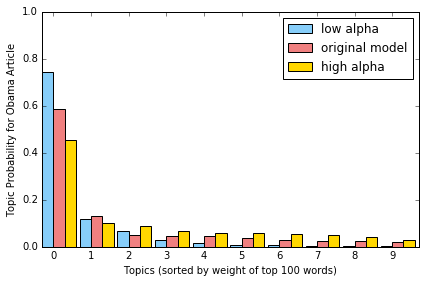

In [112]:
a = np.sort(tpm_low_alpha.predict(obama,output_type='probability')[0])[::-1]
b = np.sort(topic_model.predict(obama,output_type='probability')[0])[::-1]
c = np.sort(tpm_high_alpha.predict(obama,output_type='probability')[0])[::-1]
ind = np.arange(len(a))
width = 0.3

def param_bar_plot(a,b,c,ind,width,ylim,param,xlab,ylab):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    b1 = ax.bar(ind, a, width, color='lightskyblue')
    b2 = ax.bar(ind+width, b, width, color='lightcoral')
    b3 = ax.bar(ind+(2*width), c, width, color='gold')

    ax.set_xticks(ind+width)
    ax.set_xticklabels(range(10))
    ax.set_ylabel(ylab)
    ax.set_xlabel(xlab)
    ax.set_ylim(0,ylim)
    ax.legend(handles = [b1,b2,b3],labels=['low '+param,'original model','high '+param])

    plt.tight_layout()

param_bar_plot(a,b,c,ind,width,ylim=1.0,param='alpha',
               xlab='Topics (sorted by weight of top 100 words)',ylab='Topic Probability for Obama Article')

In [111]:
#DAF understanding
print "\n", a, "\n", b, "\n", c, "\n", ind


[ 0.72891566  0.09337349  0.07228916  0.03915663  0.03012048  0.01506024
  0.00903614  0.0060241   0.00301205  0.00301205] 
[ 0.60483871  0.10752688  0.05913978  0.05107527  0.0483871   0.04032258
  0.03494624  0.02150538  0.0188172   0.01344086] 
[ 0.46682464  0.11611374  0.0971564   0.06398104  0.05450237  0.0450237
  0.0450237   0.04028436  0.04028436  0.03080569] 
[0 1 2 3 4 5 6 7 8 9]


Here we can clearly see the smoothing enforced by the alpha parameter - notice that when alpha is low most of the weight in the topic distribution for this article goes to a single topic, but when alpha is high the weight is much more evenly distributed across the topics.

__Quiz Question:__ How many topics are assigned a weight greater than 0.3 or less than 0.05 for the article on Paul Krugman in the **low alpha** model?  Use the average results from 100 topic predictions.

In [136]:
krugman = gl.SArray([wiki_docs[int(np.where(wiki['name']=='Paul Krugman')[0])]])
p_low_alpha = average_predictions(tpm_low_alpha, krugman, 100)['average predictions']

print p_low_alpha
print p_low_alpha[(p_low_alpha>0.3) | (p_low_alpha<0.05)]
#A: 8 -1 con una p altisima + 7 con p extremadamente pequeña-

[0.6273456790123457, 0.21925925925925935, 0.061049382716049386, 0.0160493827160494, 0.015555555555555569, 0.01512345679012347, 0.013086419753086435, 0.012037037037037058, 0.010308641975308652, 0.0101851851851852]
[0.6273456790123457, 0.0160493827160494, 0.015555555555555569, 0.01512345679012347, 0.013086419753086435, 0.012037037037037058, 0.010308641975308652, 0.0101851851851852, ... ]
8


__Quiz Question:__ How many topics are assigned a weight greater than 0.3 or less than 0.05 for the article on Paul Krugman in the **high alpha** model? Use the average results from 100 topic predictions.

In [138]:
p_high_alpha = average_predictions(tpm_high_alpha, krugman, 100)['average predictions']

print p_high_alpha
print p_high_alpha[(p_high_alpha>0.3) | (p_high_alpha<0.05)]
print len(p_high_alpha[(p_high_alpha>0.3) | (p_high_alpha<0.05)])

#A: solo 2

[0.32384920634920644, 0.18742063492063477, 0.09293650793650786, 0.06003968253968247, 0.060039682539682435, 0.05984126984126974, 0.05892857142857134, 0.05809523809523798, 0.05067460317460308, 0.0481746031746031]
[0.32384920634920644, 0.0481746031746031, ... ]
2


### Changing the hyperparameter gamma

Just as we were able to see the effect of alpha by plotting topic weights for a document, we expect to be able to visualize the impact of changing gamma by plotting word weights for each topic. In this case, however, there are far too many words in our vocabulary to do this effectively. Instead, we'll plot the total weight of the top 100 words and bottom 1000 words for each topic. Below, we plot the (sorted) total weights of the top 100 words and bottom 1000 from each topic in the high, original, and low gamma models.

Now we will consider the following two models:
 - tpm_low_gamma, a model trained with gamma = 0.02 and default alpha
 - tpm_high_gamma, a model trained with gamma = 0.5 and default alpha

In [139]:
del tpm_low_alpha
del tpm_high_alpha
tpm_low_gamma = gl.load_model('lda_models/lda_low_gamma')
tpm_high_gamma = gl.load_model('lda_models/lda_high_gamma')

In [140]:
# DAF understanding
print tpm_low_gamma
print tpm_high_gamma

Class                          : TopicModel

Schema
------
Vocabulary Size                : 547462

Settings
--------
Number of Topics               : 10
alpha                          : 5.0
beta                           : 0.02
Iterations                     : 200
Training time                  : 224.977
Verbose                        : False

Accessible fields             : 
m['topics']                   : An SFrame containing the topics.
m['vocabulary']               : An SArray containing the words in the vocabulary.
Useful methods                : 
m.get_topics()                : Get the most probable words per topic.
m.predict(new_docs)           : Make predictions for new documents.
Class                          : TopicModel

Schema
------
Vocabulary Size                : 547462

Settings
--------
Number of Topics               : 10
alpha                          : 0.5
beta                           : 0.1
Iterations                     : 200
Training time                  : 257

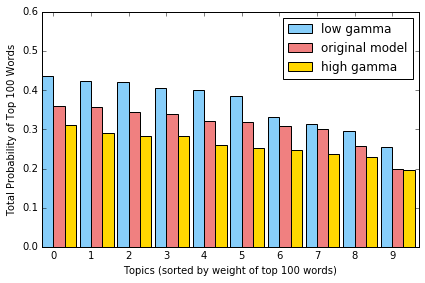

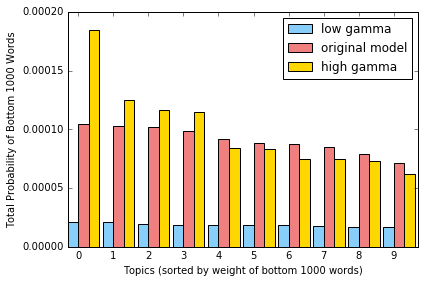

In [144]:
a_top = np.sort([sum(tpm_low_gamma.get_topics(topic_ids=[i], num_words=100)['score']) for i in range(10)])[::-1]
b_top = np.sort([sum(topic_model.get_topics(topic_ids=[i], num_words=100)['score']) for i in range(10)])[::-1]
c_top = np.sort([sum(tpm_high_gamma.get_topics(topic_ids=[i], num_words=100)['score']) for i in range(10)])[::-1]

a_bot = np.sort([sum(tpm_low_gamma.get_topics(topic_ids=[i], num_words=547462)[-1000:]['score']) for i in range(10)])[::-1]
b_bot = np.sort([sum(topic_model.get_topics(topic_ids=[i], num_words=547462)[-1000:]['score']) for i in range(10)])[::-1]
c_bot = np.sort([sum(tpm_high_gamma.get_topics(topic_ids=[i], num_words=547462)[-1000:]['score']) for i in range(10)])[::-1]

ind = np.arange(len(a))
width = 0.3
    
param_bar_plot(a_top, b_top, c_top, ind, width, ylim=0.6, param='gamma',
               xlab='Topics (sorted by weight of top 100 words)', 
               ylab='Total Probability of Top 100 Words')

param_bar_plot(a_bot, b_bot, c_bot, ind, width, ylim=0.0002, param='gamma',
               xlab='Topics (sorted by weight of bottom 1000 words)',
               ylab='Total Probability of Bottom 1000 Words')

In [143]:
#DAF understanding
print a_top, "\n", a_bot

[ 0.43711624  0.42324155  0.42015463  0.40663683  0.4006247   0.38482939
  0.33106907  0.31397317  0.29481334  0.25552301] 
[  2.13826162e-05   2.07056219e-05   1.94224871e-05   1.88730480e-05
   1.88035271e-05   1.86018784e-05   1.85210868e-05   1.79701585e-05
   1.70027510e-05   1.66846828e-05]


From these two plots we can see that the low gamma model results in higher weight placed on the top words and lower weight placed on the bottom words for each topic, while the high gamma model places relatively less weight on the top words and more weight on the bottom words. Thus increasing gamma results in topics that have a smoother distribution of weight across all the words in the vocabulary.

__Quiz Question:__ For each topic of the **low gamma model**, compute the number of words required to make a list with total probability 0.5. What is the average number of words required across all topics? (HINT: use the get\_topics() function from GraphLab Create with the cdf\_cutoff argument).

In [168]:
res = np.asarray([len(tpm_low_gamma.get_topics(topic_ids=[i], num_words=547462, cdf_cutoff=0.5)['score']) for i in range(10)])
print res
print np.mean(res)
print np.average(res)

[184 163 329 139 189 153 295 482 164 426]
252.4
252.4


__Quiz Question:__ For each topic of the **high gamma model**, compute the number of words required to make a list with total probability 0.5. What is the average number of words required across all topics? (HINT: use the get\_topics() function from GraphLab Create with the cdf\_cutoff argument).

In [174]:
res = np.asarray([len(tpm_high_gamma.get_topics(topic_ids=[i], num_words=547462, cdf_cutoff=0.5)['score']) for i in range(10)])
print res
print np.mean(res)
print np.average(res)

[ 318  519  701  545  379  384  572  467 1303  574]
576.2
576.2


We have now seen how the hyperparameters alpha and gamma influence the characteristics of our LDA topic model, but we haven't said anything about what settings of alpha or gamma are best. We know that these parameters are responsible for controlling the smoothness of the topic distributions for documents and word distributions for topics, but there's no simple conversion between smoothness of these distributions and quality of the topic model. In reality, there is no universally "best" choice for these parameters. Instead, finding a good topic model requires that we be able to both explore the output (as we did by looking at the topics and checking some topic predictions for documents) and understand the impact of hyperparameter settings (as we have in this section).